## tf-keras Conv-1d Model
Looking at the below results, one can say that this model is not promising good results!

In [1]:
# To get r2 as a metric we will use tensorflow-addons
# !pip install tensorflow-addons

In [2]:
import pandas as pd
import numpy as np 
import pickle
import time
from datetime import datetime
import sys

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns

print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# from utils import * 
# del sys.modules['utils']
# from utils import * 

Version:  2.4.1
GPU is available


In [3]:
df = pd.read_csv("./data/df_slow.csv")
df.shape
summary = df["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
mask = (df["query_time_ns"]<summary["99%"])
sum(mask)
#%%
df = df[mask]
y = df['query_time_ns']
#%%
X = df['clean_query']
X.shape, y.shape

((15375,), (15375,))

In [4]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.3)
xtrain.shape, xvalid.shape, xtest.shape, ytrain.shape, yvalid.shape, ytest.shape

((10762,), (3229,), (1384,), (10762,), (3229,), (1384,))

In [5]:
# Model constants.
max_features = 1000
embedding_dim = 200
sequence_length = 128

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
vectorize_layer.adapt(xtrain.values)

Lets test our vectorize layer

In [6]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)

model_test = tf.keras.Model(text_input, x)
model_test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 128)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


It seems it is working

In [7]:
model_test(tf.constant(["select"]))

<tf.Tensor: shape=(1, 128), dtype=int64, numpy=
array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>

Move onto model creation
I will use some callback:
- To save best weights during the training
- Scheduler for learning rate decay from epoch to epoch
- Early stoppling rule to avoid computaional cost
- Tensorboard is a tool to evaluate different models/hyperparameters

In [8]:
checkpoint_filepath = "./tmp/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_r_square',
                        mode='min',
                        save_best_only=True,
                        )   
def scheduler(epoch, lr):
    return lr * 0.8**epoch 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_r_square', 
                                patience=3,
                                restore_best_weights=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    checkpoint_callback,
    early_stopping,
    tb_callback,
]

In [9]:
tf.keras.backend.clear_session()

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1, name="predictions")(x)

model = tf.keras.Model(text_input, predictions)

model.compile(loss="mean_squared_error", 
                optimizer="adam", 
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanAbsoluteError(),
                         tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 128)               0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 200)          200200    
_________________________________________________________________
dropout (Dropout)            (None, 128, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           179328    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0     

In [10]:
epochs = 30
batch_size = 32
history = model.fit(xtrain, ytrain, 
            validation_data=(xvalid, yvalid),
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=callbacks)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
337/337 [==============================] - 28s 75ms/step - loss: 673183636098.2722 - root_mean_squared_error: 820225.2028 - mean_absolute_error: 475947.5984 - r_square: -0.1517 - val_loss: 602303234048.0000 - val_root_mean_squared_error: 776082.0000 - val_mean_absolute_error: 584513.8750 - val_r_square: 3.2616e-04
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000800000037997961.
337/337 [==============================] - 25s 74ms/step - loss: 611697821780.8284 - root_mean_squared_error: 782008.2102 - mean_absolute_error: 581491.9257 - r_square: -0.0070 - val_loss: 601211011072.0000 - val_root_mean_squared_error: 775378.0000 - val_mean_absolute_error: 557617.5625 - val_r_square: 0.0021
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005120000243186951.
337/337 [==============================] - 15s 45ms/step - loss: 600449821290.0355 - 

In [11]:
pred = model.predict(xtest)


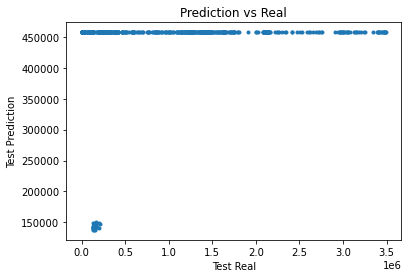

In [12]:
plt.plot(figsize=(10,5))
plt.plot(ytest, pred, ".")
plt.title("Prediction vs Real")
plt.xlabel("Test Real")
plt.ylabel("Test Prediction")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [14]:
def eval_model(model, x, y, data_type, prn = False):
    start = time.time()
    pred = model.predict(x)
    pred_time = np.round((time.time() - start),4)
    if prn:
        print(f"{data_type} - Root mean squared error     : {(mean_squared_error(y, pred, squared=False)):.2f}")
        print(f"{data_type} - Mean absolute error         : {(mean_absolute_error(y, pred)):.2f}")
        print(f"{data_type} - Coefficient of determination: {(r2_score(y, pred)):.2f}")
        print(f"{data_type} - Time elapsed                : {pred_time}\n")
    return np.round(mean_squared_error(y, pred, squared=False),1), \
            np.round(mean_absolute_error(y, pred),1), \
            np.round(r2_score(y, pred),2), \
            pred_time

In [15]:
model_name = "keras_conv1d"
model_path = "./models/" + model_name
model.save(model_path)

INFO:tensorflow:Assets written to: ./models/keras_conv1d\assets


In [16]:
from pathlib import Path
model_directory = Path(model_path)
model_size = sum(f.stat().st_size for f in model_directory.glob('**/*') if f.is_file())

In [17]:
print(f"model size                         : {model_size}")
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(model, xtrain, ytrain, data_type="Train", prn = True)
val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(model, xvalid, yvalid, data_type="Valid", prn = True)
test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(model, xtest, ytest, data_type="Test", prn = True)

model size                         : 6487298
Train - Root mean squared error     : 781090.28
Train - Mean absolute error         : 594721.07
Train - Coefficient of determination: 0.00
Train - Time elapsed                : 3.8083

Valid - Root mean squared error     : 776082.08
Valid - Mean absolute error         : 584513.99
Valid - Coefficient of determination: 0.00
Valid - Time elapsed                : 1.1968

Test - Root mean squared error     : 786705.24
Test - Mean absolute error         : 597160.26
Test - Coefficient of determination: 0.00
Test - Time elapsed                : 0.392



In [18]:
df_performance = pd.read_csv("./data/df_performance.csv")
df_performance.set_index("Model", inplace=True)
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487235.0,783907.0,558509.9,-0.00,3.8101,765779.3,551367.1,0.00,1.0263,799050.7,573156.5,-0.01,0.5737


In [19]:
df_performance.loc[model_name,:] = [model_size, tr_rmse, tr_mae, tr_r2, tr_time_elapsed,\
                              val_rmse, val_mae, val_r2, val_time_elapsed,\
                             test_rmse, test_mae, test_r2, test_time_elapsed]
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920


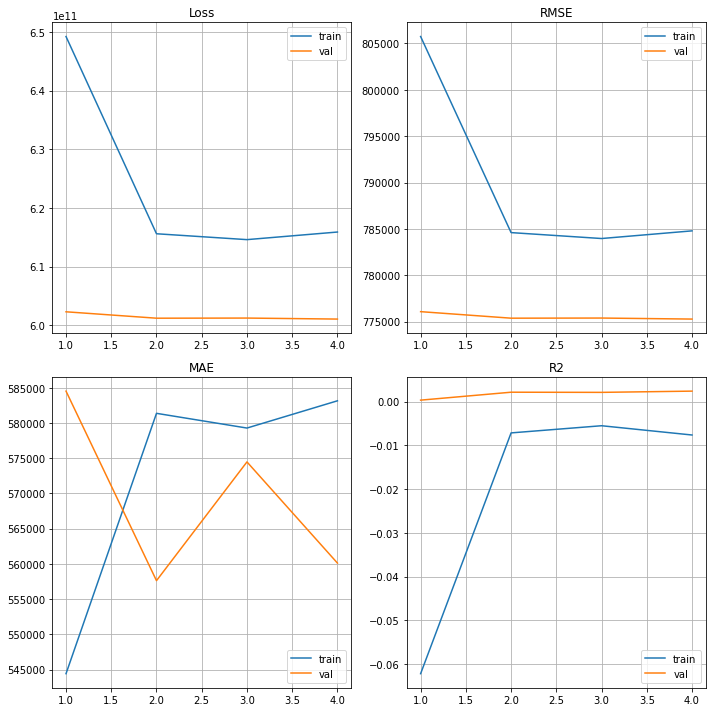

In [20]:
hist = pd.DataFrame(history.history)
x = hist.index+1
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(x, hist.loss, label="train")
plt.plot(x, hist.val_loss, label="val")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(x, hist.root_mean_squared_error, label="train")
plt.plot(x, hist.val_root_mean_squared_error, label="val")
plt.title("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(223)
plt.plot(x, hist.mean_absolute_error, label="train")
plt.plot(x, hist.val_mean_absolute_error, label="val")
plt.title("MAE")
plt.legend()
plt.grid(True)

plt.subplot(224)
plt.plot(x, hist.r_square, label="train")
plt.plot(x, hist.val_r_square, label="val")
plt.title("R2")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [21]:
df_performance.to_csv("./data/df_performance.csv",index_label='Model')

In [22]:
df_per = pd.read_csv("./data/df_performance.csv")
df_per.set_index("Model", inplace=True)
df_per

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920
